# CPEN400Q - Quantum Computing - Three-qubit VGQEC


1. This software reproduces the key results of the paper for 3-qubit VGQEC explained in report.
2. The software design decisions and framework choices are documented explained in report.
3. Discussion and documentation of software limitations is explained in report.

# Libraries

In [1]:
# Import PennyLane library for quantum circuit simulation.
import pennylane as qml

# Import NumPy for numerical operations and array handling.
import numpy as np

# Import matplotlib for plotting and visualizing results.
import matplotlib.pyplot as plt

# Unitary Functions

In [2]:
# Set of 2-design sequences for single-qubit unitary 2-design.
single_qubit_two_design = [
    '',     # Identity.
    'Y',    # Apply RY with specific angle.
    'YA',   # RY followed by RZ(2π/3).
    'YB'    # RY followed by RZ(4π/3).
]

def apply_single_two_design(two_design_string, wires):
    """
    Applies a single-qubit 2-design sequence to the given wire.

    Args:
        two_design_string (str): A string of gates to apply.
        wires (int or list[int]): The qubit wire(s) to apply the gates to.
    """
    for gate in two_design_string:
        if gate == 'Y':
            qml.RY(2*np.arccos(1/np.sqrt(3)), wires=wires)
        elif gate == 'A':
            qml.RZ(2*np.pi/3, wires=wires)
        elif gate == 'B':
            qml.RZ(4*np.pi/3, wires=wires)

def apply_sequence(sequence, wires):
    """
    Applies a sequence of single-qubit 2-design operations.

    Args:
        sequence (list[str]): List of design strings to apply.
        wires (list[int]): Wires that match with the sequence list.
    """
    for two_design in sequence:
        apply_single_two_design(two_design, wires)

def apply_inverse_sequence(sequence, wires):
    """
    Applies the adjoint of a sequence of 2-design operations.

    Args:
        sequence (list[str]): List of design strings to invert.
        wires (list[int]): Wires that match with the sequence list.
    """
    for two_design in reversed(sequence):
        apply_single_two_design_adjoint(two_design, wires)

def apply_single_two_design_adjoint(two_design_string, wires):
    """
    Applies the adjoint of a single 2-design sequence.

    Args:
        two_design_string (str): String of gates to invert.
        wires (int or list[int]): The wire(s) to apply the adjoint gates to.
    """
    for gate in reversed(two_design_string):
        if gate == 'Y':
            qml.adjoint(qml.RY)(2 * np.arccos(1 / np.sqrt(3)), wires=wires)
        elif gate == 'A':
            qml.adjoint(qml.RZ)(2 * np.pi / 3, wires=wires)
        elif gate == 'B':
            qml.adjoint(qml.RZ)(4 * np.pi / 3, wires=wires)

# Noise Functions

In [3]:
def noise_model(p_ampdamp, wires):
    """
    Applies amplitude damping noise to the specified wires.

    Args:
        p_ampdamp (float): Probability of amplitude damping (range 0 to 1).
        wires (list[int]): List of wire indices to apply noise.
    """
    for wire in wires:
        qml.AmplitudeDamping(p_ampdamp, wires=wire)

# 3-Qubit VGQEC Functions

In [4]:
def VGQEC_3_encoding(wires):
    """
    Applies a 3-qubit repetition encoding using CNOT gates.

    Args:
        wires (list[int]): List of 3 qubit wires.
    """
    for wire in wires[1:]:
        qml.CNOT(wires=[0, wire])

def VGQEC_3_encoding_variational(alpha, L, wires):
    """
    Applies a variational encoding circuit to 3 qubits.

    Args:
        alpha (array[float]): Parameters for variational layers.
        L (int): Number of variational layers.
        wires (list[int]): List of 3 qubit wires.
    """
    for layer in range(L):
        base = layer * 6  # Each layer uses 6 parameters.

        # RX gates.
        for i in range(3):
            qml.RX(alpha[base + i], wires=wires[i])

        # RY gates.
        for i in range(3):
            qml.RY(alpha[base + 3 + i], wires=wires[i])

        # CZ entangling pattern fixed.
        qml.CZ(wires=[0, 1])
        qml.CZ(wires=[1, 2])
        qml.CZ(wires=[0, 2])

def VGQEC_3_recovery_variational(beta, L, wires):
    """
    Applies a variational recovery circuit to 5 qubits.

    Args:
        beta (array[float]): Parameters for the recovery circuit.
        L (int): Number of variational layers.
        wires (list[int]): List of 5 qubit wires (includes auxiliary qubits).
    """
    # Initial RZ on all qubits.
    for i in range(5):
        qml.RZ(beta[i], wires=wires[i])
    
    param_offset = 5  # Initial offset.

    for layer in range(L):
        layer_base = param_offset + layer * 20

        # RX layer.
        for i in range(5):
            qml.RX(beta[layer_base + i], wires=wires[i])

        # RZ layer.
        for i in range(5):
            qml.RZ(beta[layer_base + 5 + i], wires=wires[i])

        # IsingZZ entangling gates (10 total).
        zz_pairs = [
            (0, 1), (1, 2), (2, 3), (3, 4),
            (0, 2), (2, 4), (1, 3), (0, 3), (1, 4), (0, 4)
        ]
        for j, (a, b) in enumerate(zz_pairs):
            qml.IsingZZ(beta[layer_base + 10 + j], wires=[wires[a], wires[b]])

    # Final RX layer.
    final_rx_offset = param_offset + L * 20
    for i in range(5):
        qml.RX(beta[final_rx_offset + i], wires=wires[i])

    # Final RZ layer.
    for i in range(5):
        qml.RZ(beta[final_rx_offset + 5 + i], wires=wires[i])

def VGQEC_3_recovery(wires):
    """
    Applies a 3-qubit repetition recovery map using CNOT and Toffoli gates.

    Args:
        wires (list[int]): List of 3 qubit wires.
    """
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 1])
    qml.Toffoli(wires=[2, 1, 0])

# 3-Qubit Repetition Functions

In [5]:
def rep_3_encoding(wires):
    """
    Applies a 3-qubit repetition encoding using CNOT gates.

    Args:
        wires (list[int]): List of 3 qubit wires.
    """
    for wire in wires[1:]:
        qml.CNOT(wires=[0, wire])
 
def rep_3_recovery(wires):
    """
    Applies a 3-qubit repetition recovery map using CNOT and Toffoli gates.

    Args:
        wires (list[int]): List of 3 qubit wires.
    """
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 1])
    qml.Toffoli(wires=[2, 1, 0])

# 3-Qubit Repetition and no protection for noise parameters

In [6]:
# Create 3-qubit mixed-state simulator device.
dev3_circuit = qml.device("default.mixed", wires=3, shots=None)

@qml.qnode(dev3_circuit)
def circuit_3_noprotection(noise_params):
    """
    Quantum circuit without error protection.
    
    Applies a randomly sampled 1-qubit 2-design to qubit 0,
    simulates amplitude damping noise on all 3 qubits,
    and then applies the inverse 2-design before measuring.

    Args:
        noise_params (float): Amplitude damping probability.

    Returns:
        float: Expectation value of the |0⟩⟨0| projector on qubit 0.
    """
    sequence = np.random.choice(single_qubit_two_design)
    apply_sequence(sequence, wires=0)
    noise_model(noise_params, wires=[0, 1, 2])
    apply_inverse_sequence(sequence, wires=0)
    return qml.expval(qml.Projector([0], wires=0))

@qml.qnode(dev3_circuit)
def circuit_rep3_protected(noise_params):
    """
    Quantum circuit with repetition code protection.

    Applies a randomly sampled 1-qubit 2-design to qubit 0, encodes logical information
    using the repetition code, simulates amplitude damping noise,
    applies the recovery, and then applies the inverse 2-design before measuring.

    Args:
        noise_params (float): Amplitude damping probability.

    Returns:
        float: Expectation value of the |0⟩⟨0| projector on qubit 0.
    """
    sequence = np.random.choice(single_qubit_two_design)
    apply_sequence(sequence, wires=0)
    rep_3_encoding(wires=[0, 1, 2])
    noise_model(noise_params, wires=[0, 1, 2])
    rep_3_recovery(wires=[0, 1, 2])
    apply_inverse_sequence(sequence, wires=0)
    return qml.expval(qml.Projector([0], wires=0))

def compute_fc(fe, d = 2):
    """
    Converts entanglement fidelity to average gate fidelity.

    Args:
        fe (float): Entanglement fidelity.
        d (int): Dimension of the system.

    Returns:
        float: Average gate fidelity.
    """
    return (fe*(d + 1) - 1) / d

list_noise_params = [] # List for noise parameters.
fid_no_protection = [] # List for 3-qubit no protection channel fidelity.
fid_protected = [] # List for 3-qubit protection channel fidelity.
N_k = 20 # Number of 2-design samples to average over.
np.random.seed(0) # Reproducibility.

noise_params = 0
while noise_params <= 0.5:
    total_no_prot = []
    total_prot = []

    # Average over N_k 2-design samples.
    for _ in range(N_k):
        total_no_prot.append(circuit_3_noprotection(noise_params))
        total_prot.append(circuit_rep3_protected(noise_params))

    # Estimate average entanglement fidelities.
    mean_no_prot = np.mean(total_no_prot)
    mean_prot = np.mean(total_prot)

    # Convert to average gate fidelities.
    fc_no_prot = compute_fc(mean_no_prot)
    fc_prot = compute_fc(mean_prot)

    # Record values to the lists.
    fid_no_protection.append(fc_no_prot)
    fid_protected.append(fc_prot)
    list_noise_params.append(noise_params)

    # Print progress.
    print(f"λ = {noise_params:.2f}, no prot: {fc_no_prot:.4f}, repetition: {fc_prot:.4f}")

    # Increment noise level.
    noise_params += 0.05

λ = 0.00, no prot: 1.0000, repetition: 1.0000
λ = 0.05, no prot: 0.9748, repetition: 0.9637
λ = 0.10, no prot: 0.9527, repetition: 0.9252
λ = 0.15, no prot: 0.9133, repetition: 0.8684
λ = 0.20, no prot: 0.8904, repetition: 0.8430
λ = 0.25, no prot: 0.8964, repetition: 0.8000
λ = 0.30, no prot: 0.8329, repetition: 0.7562
λ = 0.35, no prot: 0.7910, repetition: 0.6710
λ = 0.40, no prot: 0.8015, repetition: 0.5733
λ = 0.45, no prot: 0.7583, repetition: 0.5976
λ = 0.50, no prot: 0.7105, repetition: 0.5817


# Optimization 3-Qubit VGQEC for noise parameters

In [7]:
# Import torch library for quantum circuit optimization.
import torch

# Number of samples for 2-design averaging.
N_k = 20

# Define the 5-qubit mixed-state simulator device.
dev_opt = qml.device("default.mixed", wires=5, shots=None)

@qml.qnode(dev_opt, interface="torch", diff_method="backprop")
def qnode(params, sequence, noise_params):
    """
    Quantum circuit with encoding, recovery and parameterized variational circuit for 3-qubit VGQEC.
    
    Applies a pre-sampled 2-design, original encoding, variational encoding, noise model,
    variational recovery, and inverse of the 2-design before measurement.

    Args:
        params (torch.Tensor): Full parameter vector (split into alpha and beta).
        sequence (list[str]): List of 2-design gate labels.
        noise_params (float): Amplitude damping probability.

    Returns:
        torch.Tensor: Expectation value of the |0⟩⟨0| projector on qubit 0.
    """
    a = params[:12] # Variational encoding parameters.
    b = params[12:] # Variational recovery parameters.

    apply_sequence(sequence, wires=0)
    VGQEC_3_encoding(wires=[0, 1, 2])
    VGQEC_3_encoding_variational(a, 2, wires=[0, 1, 2])
    noise_model(noise_params, wires=[0, 1, 2])
    VGQEC_3_recovery_variational(b, 3, wires=[0, 1, 2, 3, 4])
    apply_inverse_sequence(sequence, wires=0)

    return qml.expval(qml.Projector([0], wires=0))

def circuit_opt_torch(params, sequences, noise_params):
    """
    Cost function for variational optimization.

    Runs the QNode over multiple pre-sampled 2-design sequences and returns
    the negative average fidelity to maximize.

    Args:
        params (torch.Tensor): Full parameter vector.
        sequences (list[list[str]]): List of 2-design sequences.
        noise_params (float): Amplitude damping probability.

    Returns:
        torch.Tensor: Negative average fidelity over samples.
    """
    wrapped_params = params % (2 * np.pi) # Bound parameter periodicity.
    fidelities = [qnode(wrapped_params, seq, noise_params) for seq in sequences]
    return -torch.mean(torch.stack(fidelities))

# Optimization loop
def torch_optimize(init_params, step_num, noise_params, verbose=False):
    """
    Runs L-BFGS optimization on the variational circuit.

    Args:
        init_params (np.ndarray): Initial parameter guess.
        step_num (int): Number of optimization steps.
        noise_params (float): Amplitude damping probability for the noise model.
        verbose (bool): If True, prints intermediate cost values.

    Returns:
        Tuple[np.ndarray, list[float]]:
            - Final optimized parameter values.
            - History of cost function values per step.
    """
    # Device selection (GPU or CPU).
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize trainable parameters.
    params = torch.tensor(init_params, dtype=torch.float64, requires_grad=True, device=device)

    # Setup L-BFGS optimizer.
    optimizer = torch.optim.LBFGS([params], max_iter=20, history_size=10, line_search_fn="strong_wolfe")
    
    costs = []

    # # Pre-sample 2-design sequences.
    sequences = [
        [np.random.choice(single_qubit_two_design) for _ in range(1)]  # k = 1 element sequence for each sample.
        for _ in range(N_k)
    ]

    # Require for L-BFGS optimizer.
    for i in range(step_num):
        def closure():
            optimizer.zero_grad()
            cost = circuit_opt_torch(params, sequences, noise_params)
            if not cost.requires_grad:
                raise RuntimeError("Cost does not require grad!")
            cost.backward()
            return cost

        cost = closure()
        optimizer.step(closure)
        costs.append(cost.item())

        # Print cost every 2 steps.
        if verbose and (i + 1) % 2 == 0:
            print(f"Step {i + 1}, Cost: {cost.item():.6f}")

    # Return detached parameters and cost history.
    with torch.no_grad():
        final_params = params.detach().cpu().numpy()

    return final_params, costs

/Applications/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Initialize amplitude damping noise parameter.
noise_params = 0

# Store channel fidelities at each noise level.
all_fc = []

# List of amplitude damping probabilities.
all_noise = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Run optimization.
for noise_params in all_noise:
        
    # Set random seed for reproducibility of initial parameters.
    np.random.seed(0)

    # Initialize circuit parameters from normal distribution.
    initial_params = np.random.normal(0, np.pi, 87)

    # Run PyTorch L-BFGS optimizer.
    step_num = 10
    opt_params, costs = torch_optimize(initial_params, step_num, noise_params, verbose=True)

    fe = -costs[-1] # Average entanglement fidelity.
    d = 2 # Dimension of Hilbert space.

    fc = compute_fc(fe, d) # Compute channel fidelity.

    # Print progress.
    print("noise:", noise_params, "; Avg Cost:", -costs[-1], "; Channel fidelity:", fc, "\n")

    all_fc.append(fc)

Step 2, Cost: -0.999882
Step 4, Cost: -0.999999
Step 6, Cost: -0.999999
Step 8, Cost: -0.999999
Step 10, Cost: -0.999999
noise: 0 ; Avg Cost: 0.9999987889141575 ; Channel fidelity: 0.9999981833712361 

Step 2, Cost: -0.971312
Step 4, Cost: -0.984667
Step 6, Cost: -0.990743
Step 8, Cost: -0.990881
Step 10, Cost: -0.990881
noise: 0.05 ; Avg Cost: 0.9908811476985997 ; Channel fidelity: 0.9863217215478994 

Step 2, Cost: -0.946237
Step 4, Cost: -0.978294
Step 6, Cost: -0.981528
Step 8, Cost: -0.981540
Step 10, Cost: -0.981540
noise: 0.1 ; Avg Cost: 0.9815400922006041 ; Channel fidelity: 0.9723101383009061 

Step 2, Cost: -0.923612
Step 4, Cost: -0.969323
Step 6, Cost: -0.969412
Step 8, Cost: -0.969412
Step 10, Cost: -0.969412
noise: 0.15 ; Avg Cost: 0.969412207071856 ; Channel fidelity: 0.9541183106077842 

Step 2, Cost: -0.900364
Step 4, Cost: -0.962045
Step 6, Cost: -0.962088
Step 8, Cost: -0.962088
Step 10, Cost: -0.962088
noise: 0.2 ; Avg Cost: 0.9620880370205404 ; Channel fidelity: 0.

# Display plot for all methods of 3-Qubits for noise parameters

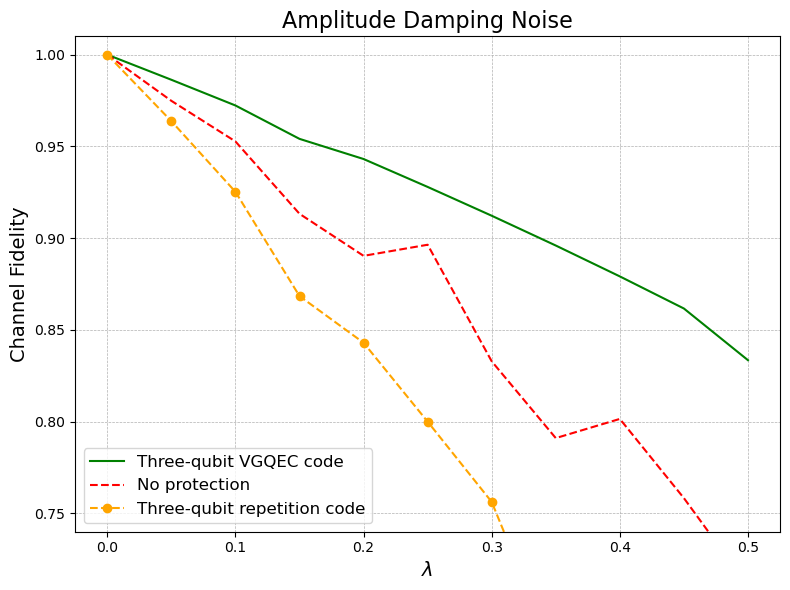

In [9]:
# Create a figure with larger size.
plt.figure(figsize=(8, 6))

# Plot VGQEC fidelity.
plt.plot(list_noise_params, all_fc, color='green', label='Three-qubit VGQEC code')

# Plot fidelity with no error correction.
plt.plot(list_noise_params, fid_no_protection, 'r--', label='No protection')

# Plot fidelity with 3-qubit repetition code.
plt.plot(list_noise_params, fid_protected, 'orange', linestyle='--', marker='o', label='Three-qubit repetition code')

# Label the x-axis as lambda.
plt.xlabel(r'$\lambda$', fontsize=14)

# Label the y-axis.
plt.ylabel('Channel Fidelity', fontsize=14)

# Title of the plot.
plt.title('Amplitude Damping Noise', fontsize=16)

plt.ylim(0.74, 1.01)

plt.grid(True, linestyle='--', linewidth=0.5)

plt.legend(loc='lower left', fontsize=12, frameon=True)

plt.tight_layout()

# Display the plot.
plt.show()